In [94]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from string import ascii_letters
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

%matplotlib inline
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('../data/track_audio_dataset.csv', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77629 entries, 0 to 77628
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        77629 non-null  object 
 1   artist_name       77629 non-null  object 
 2   album_name        77629 non-null  object 
 3   genre             77629 non-null  object 
 4   duration_ms       77629 non-null  int64  
 5   popularity        77629 non-null  int64  
 6   explicit          77629 non-null  bool   
 7   track_id          77629 non-null  object 
 8   artist_id         77629 non-null  object 
 9   danceability      77629 non-null  float64
 10  energy            77629 non-null  float64
 11  key               77629 non-null  int64  
 12  loudness          77629 non-null  float64
 13  mode              77629 non-null  int64  
 14  speechiness       77629 non-null  float64
 15  acousticness      77629 non-null  float64
 16  instrumentalness  77629 non-null  float6

# Data Cleaning

In [4]:
# Replace booleans with integers
df.explicit = df.explicit.astype(int)

# Convert from milliseconds to seconds
df['duration_s'] = np.round(df.duration_ms/1000,0)

In [5]:
df.head()

,track_name,artist_name,album_name,genre,duration_ms,popularity,explicit,track_id,artist_id,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s
0,Hold On,Chord Overstreet,Hold On,acoustic,198853,83,0,5vjLSffimiIP26QG5WcN2K,5D3muNJhYYunbRkh3FKgX0,0.618,...,2,-9.681,1,0.0526,0.4690,0.0,0.0829,0.167,119.949,199.0
1,I'm Yours,Jason Mraz,We Sing. We Dance. We Steal Things.,acoustic,242186,83,0,1EzrEOXmMH3G43AXT1y7pA,4phGZZrJZRo4ElhRtViYdl,0.686,...,11,-8.322,1,0.0468,0.5950,0.0,0.1050,0.718,150.953,242.0
2,I Won't Give Up,Jason Mraz,Love Is a Four Letter Word (Deluxe Edition),acoustic,240165,73,0,53QF56cjZA9RTuuMZDrSA6,4phGZZrJZRo4ElhRtViYdl,0.585,...,4,-10.058,1,0.0398,0.6940,0.0,0.1150,0.142,136.703,240.0
3,Come On Get Higher,Matt Nathanson,Some Mad Hope,acoustic,215173,72,0,38YgZVHPWOWsKrsCXz6JyP,4NGiEU3Pkd8ASRyQR30jcA,0.672,...,9,-5.699,1,0.0297,0.2410,0.0,0.0848,0.617,92.018,215.0
4,Love Song,Sara Bareilles,Little Voice,acoustic,258826,75,0,4E6cwWJWZw2zWf7VFbH7wf,2Sqr0DXoaYABbjBo9HaMkM,0.583,...,2,-3.142,0,0.0301,0.0208,0.0,0.1880,0.573,123.055,259.0


# Exploratory Data Analysis 

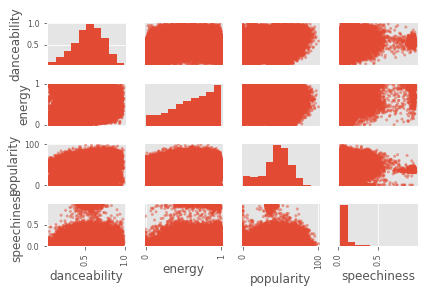

In [6]:
pd.plotting.scatter_matrix(df[['danceability','energy','popularity','speechiness']])
plt.tight_layout();

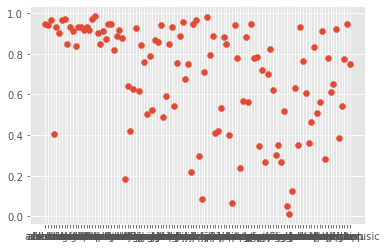

In [7]:
# Look for class imbalance across genres
genre_TracksPer1000 = df.groupby('genre').count().track_name / 1000

fig, ax = plt.subplots()
ax.axes.xaxis.set_ticks([])

ax.scatter(genre_TracksPer1000.index, genre_TracksPer1000.values)

In [8]:
genre_TracksPer1000.sort_values()

genre
reggaeton    0.012
reggae       0.050
latino       0.066
indie-pop    0.085
rock         0.126
             ...  
indian       0.968
club         0.971
bluegrass    0.971
iranian      0.979
comedy       0.985
Name: track_name, Length: 112, dtype: float64

In [9]:
genre_TracksPer1000['pop']

0.266

In [10]:
genre_TracksPer1000[genre_TracksPer1000 > .8]

genre
acoustic          0.949
afrobeat          0.940
alt-rock          0.967
ambient           0.932
anime             0.901
black-metal       0.967
bluegrass         0.971
blues             0.846
brazil            0.934
breakbeat         0.911
british           0.837
cantopop          0.930
chicago-house     0.930
children          0.915
chill             0.930
classical         0.918
club              0.971
comedy            0.985
country           0.903
dance             0.848
dancehall         0.910
death-metal       0.875
deep-house        0.946
detroit-techno    0.949
disco             0.820
disney            0.889
drum-and-bass     0.918
dub               0.879
emo               0.925
forro             0.842
gospel            0.867
goth              0.858
grindcore         0.940
guitar            0.850
happy             0.930
hardstyle         0.889
heavy-metal       0.955
idm               0.949
indian            0.968
iranian           0.979
j-idol            0.889
k-pop     

<BarContainer object of 5 artists>

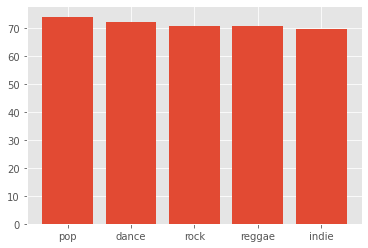

In [11]:
popularity_avg_by_genre = df.groupby('genre').mean().popularity
sorted_popularity_genre = popularity_avg_by_genre.sort_values(axis=0,ascending=False)

fig, ax = plt.subplots()
ax.bar(sorted_popularity_genre.index[:5],sorted_popularity_genre.values[:5])

In [82]:
# Creating a dataframe of only popular genres with a large number of data points (>800) to mitigate class imbalance
selected_genres=['acoustic','alt-rock','blues','classical',
                 'country','dance','deep-house','disco',
                 'hardstyle','heavy-metal','k-pop','tango']
subset_df = df[df['genre'].isin(selected_genres)].copy()

In [83]:
subset_df.head()

,track_name,artist_name,album_name,genre,duration_ms,popularity,explicit,track_id,artist_id,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s
0,Hold On,Chord Overstreet,Hold On,acoustic,198853,83,0,5vjLSffimiIP26QG5WcN2K,5D3muNJhYYunbRkh3FKgX0,0.618,...,2,-9.681,1,0.0526,0.4690,0.0,0.0829,0.167,119.949,199.0
1,I'm Yours,Jason Mraz,We Sing. We Dance. We Steal Things.,acoustic,242186,83,0,1EzrEOXmMH3G43AXT1y7pA,4phGZZrJZRo4ElhRtViYdl,0.686,...,11,-8.322,1,0.0468,0.5950,0.0,0.1050,0.718,150.953,242.0
2,I Won't Give Up,Jason Mraz,Love Is a Four Letter Word (Deluxe Edition),acoustic,240165,73,0,53QF56cjZA9RTuuMZDrSA6,4phGZZrJZRo4ElhRtViYdl,0.585,...,4,-10.058,1,0.0398,0.6940,0.0,0.1150,0.142,136.703,240.0
3,Come On Get Higher,Matt Nathanson,Some Mad Hope,acoustic,215173,72,0,38YgZVHPWOWsKrsCXz6JyP,4NGiEU3Pkd8ASRyQR30jcA,0.672,...,9,-5.699,1,0.0297,0.2410,0.0,0.0848,0.617,92.018,215.0
4,Love Song,Sara Bareilles,Little Voice,acoustic,258826,75,0,4E6cwWJWZw2zWf7VFbH7wf,2Sqr0DXoaYABbjBo9HaMkM,0.583,...,2,-3.142,0,0.0301,0.0208,0.0,0.1880,0.573,123.055,259.0


In [84]:
subset_df.columns

Index(['track_name', 'artist_name', 'album_name', 'genre', 'duration_ms',
       'popularity', 'explicit', 'track_id', 'artist_id', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s'],
      dtype='object')

In [95]:
audio_features = ['danceability','energy','key','loudness',
                  'mode','speechiness','acousticness',
                  'instrumentalness','liveness','valence',
                  'tempo']

In [98]:
subset_df[audio_features]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949
1,0.686,0.4570,11,-8.322,1,0.0468,0.5950,0.000000,0.1050,0.7180,150.953
2,0.585,0.3030,4,-10.058,1,0.0398,0.6940,0.000000,0.1150,0.1420,136.703
3,0.672,0.6230,9,-5.699,1,0.0297,0.2410,0.000000,0.0848,0.6170,92.018
4,0.583,0.7860,2,-3.142,0,0.0301,0.0208,0.000000,0.1880,0.5730,123.055
...,...,...,...,...,...,...,...,...,...,...,...
74218,0.412,0.3930,6,-10.250,0,0.0371,0.7020,0.085500,0.1600,0.5730,116.802
74219,0.780,0.2770,2,-11.989,0,0.0456,0.6760,0.349000,0.1180,0.7760,135.662
74220,0.235,0.3740,4,-11.206,0,0.0337,0.7280,0.000102,0.1870,0.3390,126.144
74221,0.503,0.1510,0,-11.434,1,0.0437,0.9240,0.000019,0.1660,0.5260,118.682


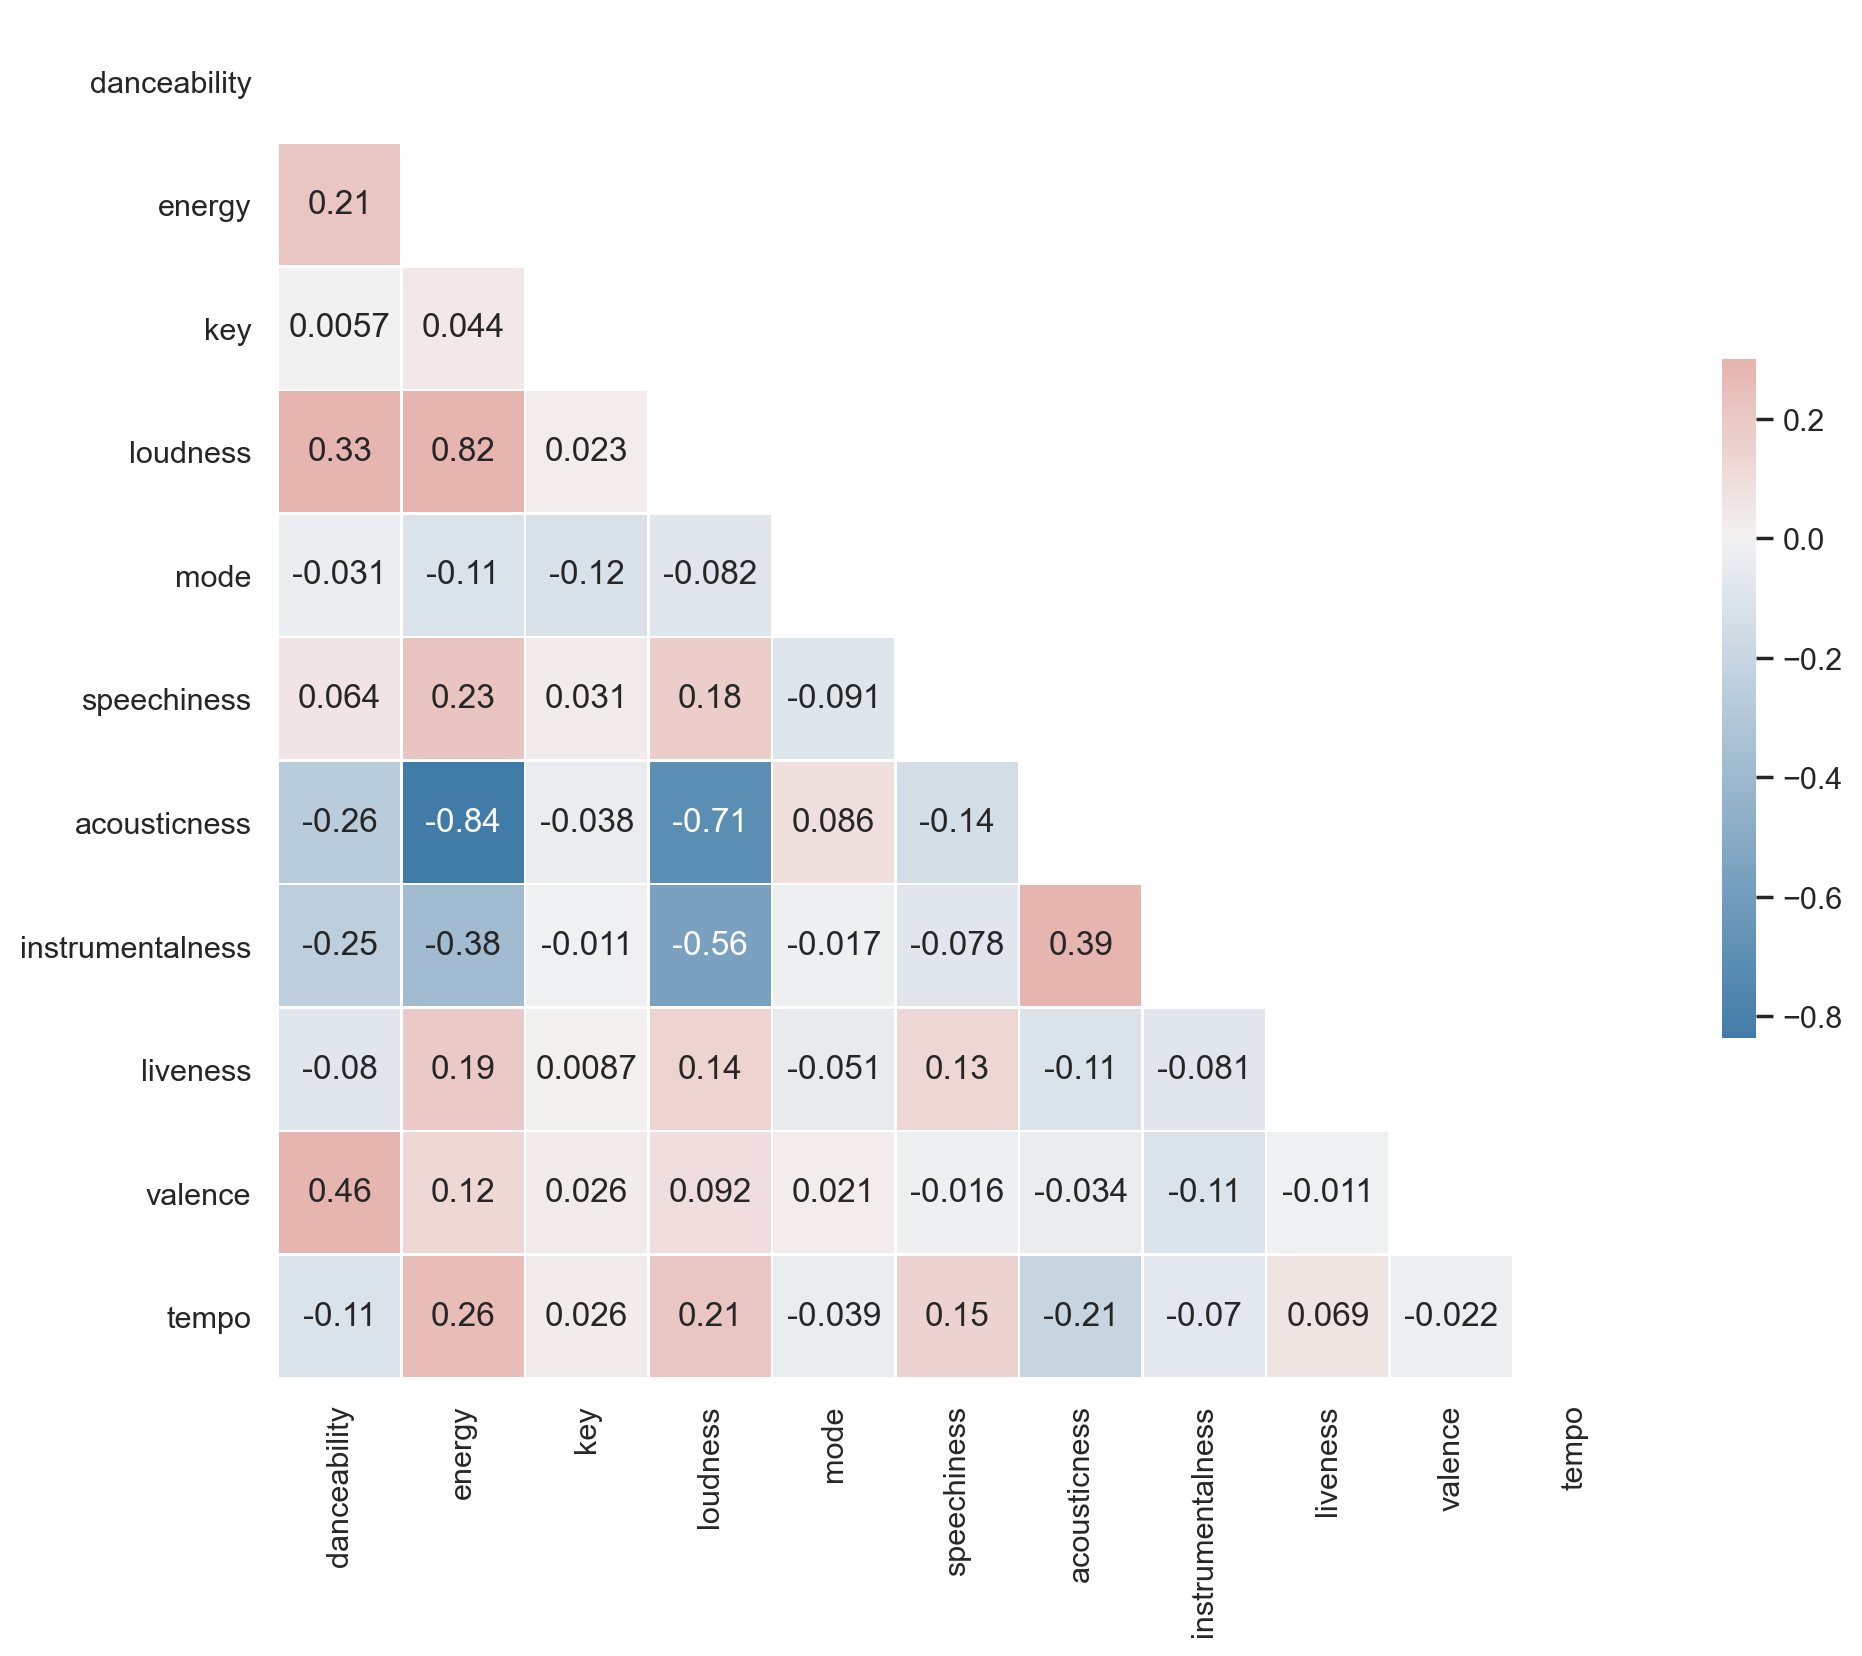

In [131]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = subset_df[audio_features].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9), dpi=200)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})

plt.savefig('../imgs/audio_features_correlation_matrix.png')

In [136]:
subset_df.groupby('genre')

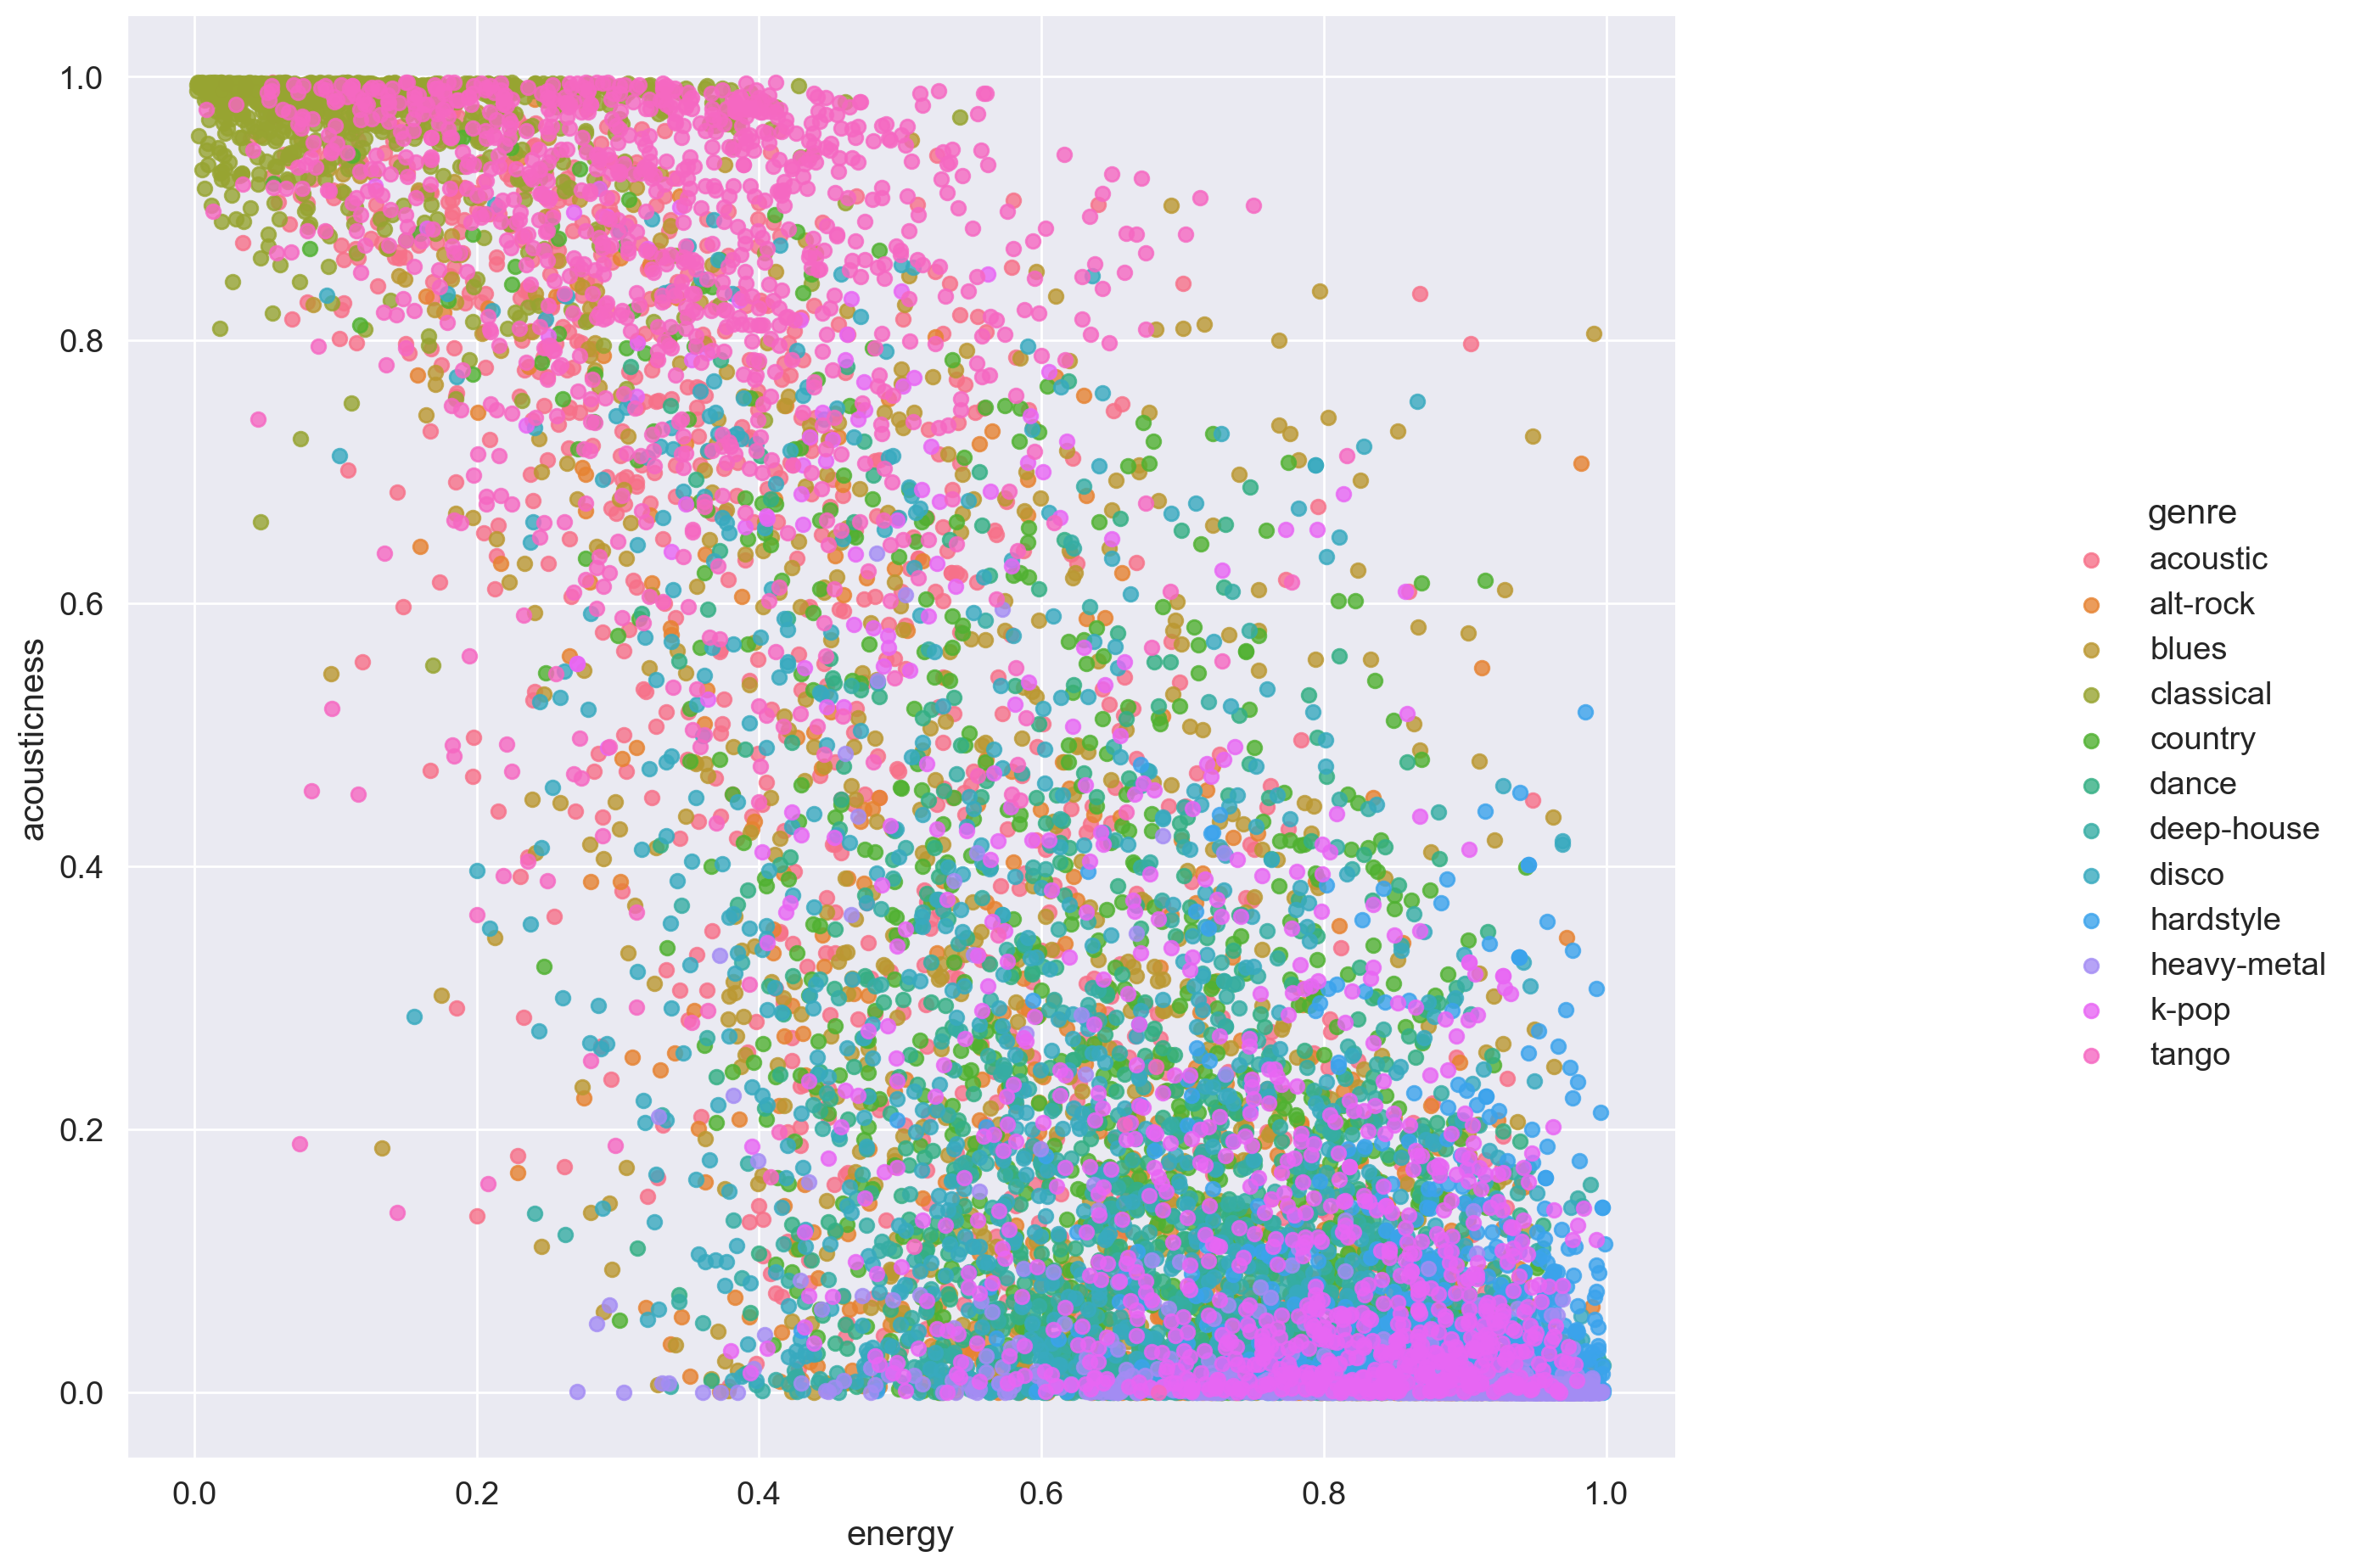

In [152]:
sns.set(font_scale=1.25)

sns.lmplot(x='energy',y='acousticness', data=subset_df, hue='genre', fit_reg=False)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.rcParams['figure.dpi'] = 200
plt.savefig('../imgs/acousticness_vs_energy_per_genre.png')
plt.show()

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['acoustic' 'acoustic' 'acoustic' ... 'tango' 'tango' 'tango']

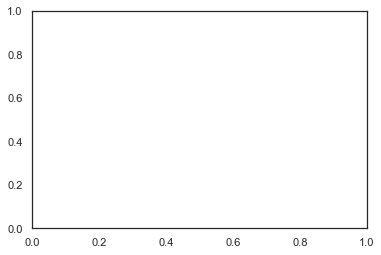

In [137]:
plt.scatter(subset_df.energy.values, subset_df.acousticness.values, alpha=0.2,
            c=subset_df.genre.values, cmap='viridis')

In [ ]:
fig, ax = plt.subplots(figsize=(10,10), dpi=200)
ax.scatter(subset_df.energy.values, subset_df.acousticness.values)

import matplotlib.pyplot as plt
import numpy as np

# plot style
plt.rcParams['figure.figsize'] = (16.0, 10.0)
plt.style.use('ggplot')

# create list of data lists
data = [std_colomns1, std_colomns2, std_colomns3, std_colomns4]

# plot data and print median
for i, d in enumerate(data, 1):
    plt.plot(d, marker='.', linestyle='none', markersize=7, label=f'col_{i}')
    print(f'Median col_{i}: {np.median(d)}')

# format plot
plt.xticks(range(0, 19, 1))
plt.yticks(range(1, 21, 1))
plt.ylabel('Values')
plt.xlabel('Index')
plt.legend()
plt.show()


In [ ]:
audio_features = ['danceability','energy','key','loudness',
                  'mode','speechiness','acousticness',
                  'instrumentalness','liveness','valence',
                  'tempo']
fig, axs = plt.subplots(len(audio_features),1,figsize=(10,10),dpi=100)

for i, ax in enumerate(axs.flatten()):
    ax.scatter()

In [15]:
# Remove non-numeric or unnecessary rows
subset_df.drop(['track_id','artist_id','duration_ms','track_name','artist_name','album_name'], axis=1, inplace=True)
full_df = df.drop(['track_id','artist_id','duration_ms','track_name','artist_name','album_name'], axis=1)

In [16]:
subset_df

,genre,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s
0,acoustic,83,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,199.0
1,acoustic,83,0,0.686,0.4570,11,-8.322,1,0.0468,0.5950,0.000000,0.1050,0.7180,150.953,242.0
2,acoustic,73,0,0.585,0.3030,4,-10.058,1,0.0398,0.6940,0.000000,0.1150,0.1420,136.703,240.0
3,acoustic,72,0,0.672,0.6230,9,-5.699,1,0.0297,0.2410,0.000000,0.0848,0.6170,92.018,215.0
4,acoustic,75,0,0.583,0.7860,2,-3.142,0,0.0301,0.0208,0.000000,0.1880,0.5730,123.055,259.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74218,tango,17,0,0.412,0.3930,6,-10.250,0,0.0371,0.7020,0.085500,0.1600,0.5730,116.802,193.0
74219,tango,18,0,0.780,0.2770,2,-11.989,0,0.0456,0.6760,0.349000,0.1180,0.7760,135.662,173.0
74220,tango,13,0,0.235,0.3740,4,-11.206,0,0.0337,0.7280,0.000102,0.1870,0.3390,126.144,184.0
74221,tango,13,0,0.503,0.1510,0,-11.434,1,0.0437,0.9240,0.000019,0.1660,0.5260,118.682,184.0


# Machine Learning

I am stratifying all splits for the data since we have a slight class imbalance.

In [18]:
# Initialize Features and Target
X = subset_df.copy()
y = X.pop('genre')

Xf = full_df.copy()
yf = Xf.pop('genre')

# Establish Train/Validation-Test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
Xf_train_val, Xf_test, yf_train_val, yf_test = train_test_split(Xf, yf, test_size=0.1, stratify=yf)

In [19]:
# Traditional train-test split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val)
Xf_train, Xf_val, yf_train, yf_val = train_test_split(Xf_train_val, yf_train_val, test_size=0.2, stratify=yf_train_val)

Class= acoustic, n= 949 (1.22%)
Class= afrobeat, n= 940 (1.21%)
Class= alt-rock, n= 967 (1.25%)
Class= alternative, n= 404 (0.52%)
Class= ambient, n= 932 (1.20%)
Class= anime, n= 901 (1.16%)
Class= black-metal, n= 967 (1.25%)
Class= bluegrass, n= 971 (1.25%)
Class= blues, n= 846 (1.09%)
Class= brazil, n= 934 (1.20%)
Class= breakbeat, n= 911 (1.17%)
Class= british, n= 837 (1.08%)
Class= cantopop, n= 930 (1.20%)
Class= chicago-house, n= 930 (1.20%)
Class= children, n= 915 (1.18%)
Class= chill, n= 930 (1.20%)
Class= classical, n= 918 (1.18%)
Class= club, n= 971 (1.25%)
Class= comedy, n= 985 (1.27%)
Class= country, n= 903 (1.16%)
Class= dance, n= 848 (1.09%)
Class= dancehall, n= 910 (1.17%)
Class= death-metal, n= 875 (1.13%)
Class= deep-house, n= 946 (1.22%)
Class= detroit-techno, n= 949 (1.22%)
Class= disco, n= 820 (1.06%)
Class= disney, n= 889 (1.15%)
Class= drum-and-bass, n= 918 (1.18%)
Class= dub, n= 879 (1.13%)
Class= dubstep, n= 186 (0.24%)
Class= edm, n= 643 (0.83%)
Class= electro, 

<BarContainer object of 112 artists>

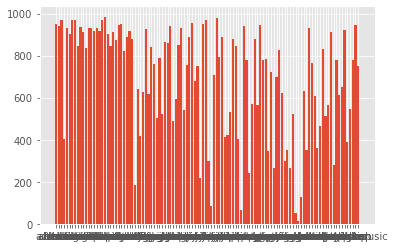

In [36]:
# view class imbalance in full dataset
counter = Counter(yf)
for k,v in counter.items():
    per = v / len(yf) * 100
    print(f'Class= {k}, n= {v} ({per:.2f}%)')
    
fig, ax = plt.subplots()
ax.bar(counter.keys(), counter.values())

## Dummy Classifier

In [21]:
# Dummy Classifier
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
print(dummy.score(X_val, y_val))

dummyf = DummyClassifier()
dummyf.fit(Xf_train, yf_train)
print(dummyf.score(Xf_val, yf_val))

0.08299180327868852
0.00894518391298125


## kNN

In [24]:
# Out of box score
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
print(knn_clf.score(X_val, y_val))

knn_clf = KNeighborsClassifier()
knn_clf.fit(Xf_train, yf_train)
print(knn_clf.score(Xf_val, yf_val))

0.49026639344262296
0.13009875483039932


In [39]:
# Look at different numbers of nearest neighbors
max_k = 0
max_score = 0
for k in range(1,50):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, y_train)
    score = classifier.score(X_val, y_val)
    # print(f'k = {k}, accuracy = {score}')
    if score > max_score:
        max_k = k
        max_score = score
        
print(f'best k = {max_k}, accuracy = {max_score}')

best k = 8, accuracy = 0.5087090163934426


In [40]:
# Look at different numbers of nearest neighbors
max_k = 0
max_score = 0
for k in range(1,50):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(Xf_train, yf_train)
    score = classifier.score(Xf_val, yf_val)
    # print(f'k = {k}, accuracy = {score}')
    if score > max_score:
        max_k = k
        max_score = score
        
print(f'best k = {max_k}, accuracy = {max_score}')

best k = 36, accuracy = 0.16451982252755118


In [45]:
def cross_val(X_train, y_train, k=3, n=8):
    '''
    Returns accuracy for stratified k-fold cross validation.
    Stratified K-fold is used since we have many classes and
    we want to preserve some amount of each class in each split.
    '''
    skf = StratifiedKFold(n_splits=k)
    accuracy = np.empty(k)
    
    for i, (train, test) in enumerate(skf.split(X_train, y_train)):
        classifier = KNeighborsClassifier(n_neighbors=n)
        classifier.fit(X_train.iloc[train], y_train.iloc[train])
        accuracy[i] = classifier.score(X_train.iloc[test],y_train.iloc[test])
        
    return np.mean(accuracy)

In [46]:
cross_val(X_train, y_train, k=5)

0.494748515553164

In [47]:
cross_val(Xf_train, yf_train, k=5, n=36)

0.15930727346092508

In [24]:
cross_val(X_train, y_train, k=10)

0.5005077317049148

In [25]:
cross_val(X_train, y_train, k=20)

0.5008918617614271

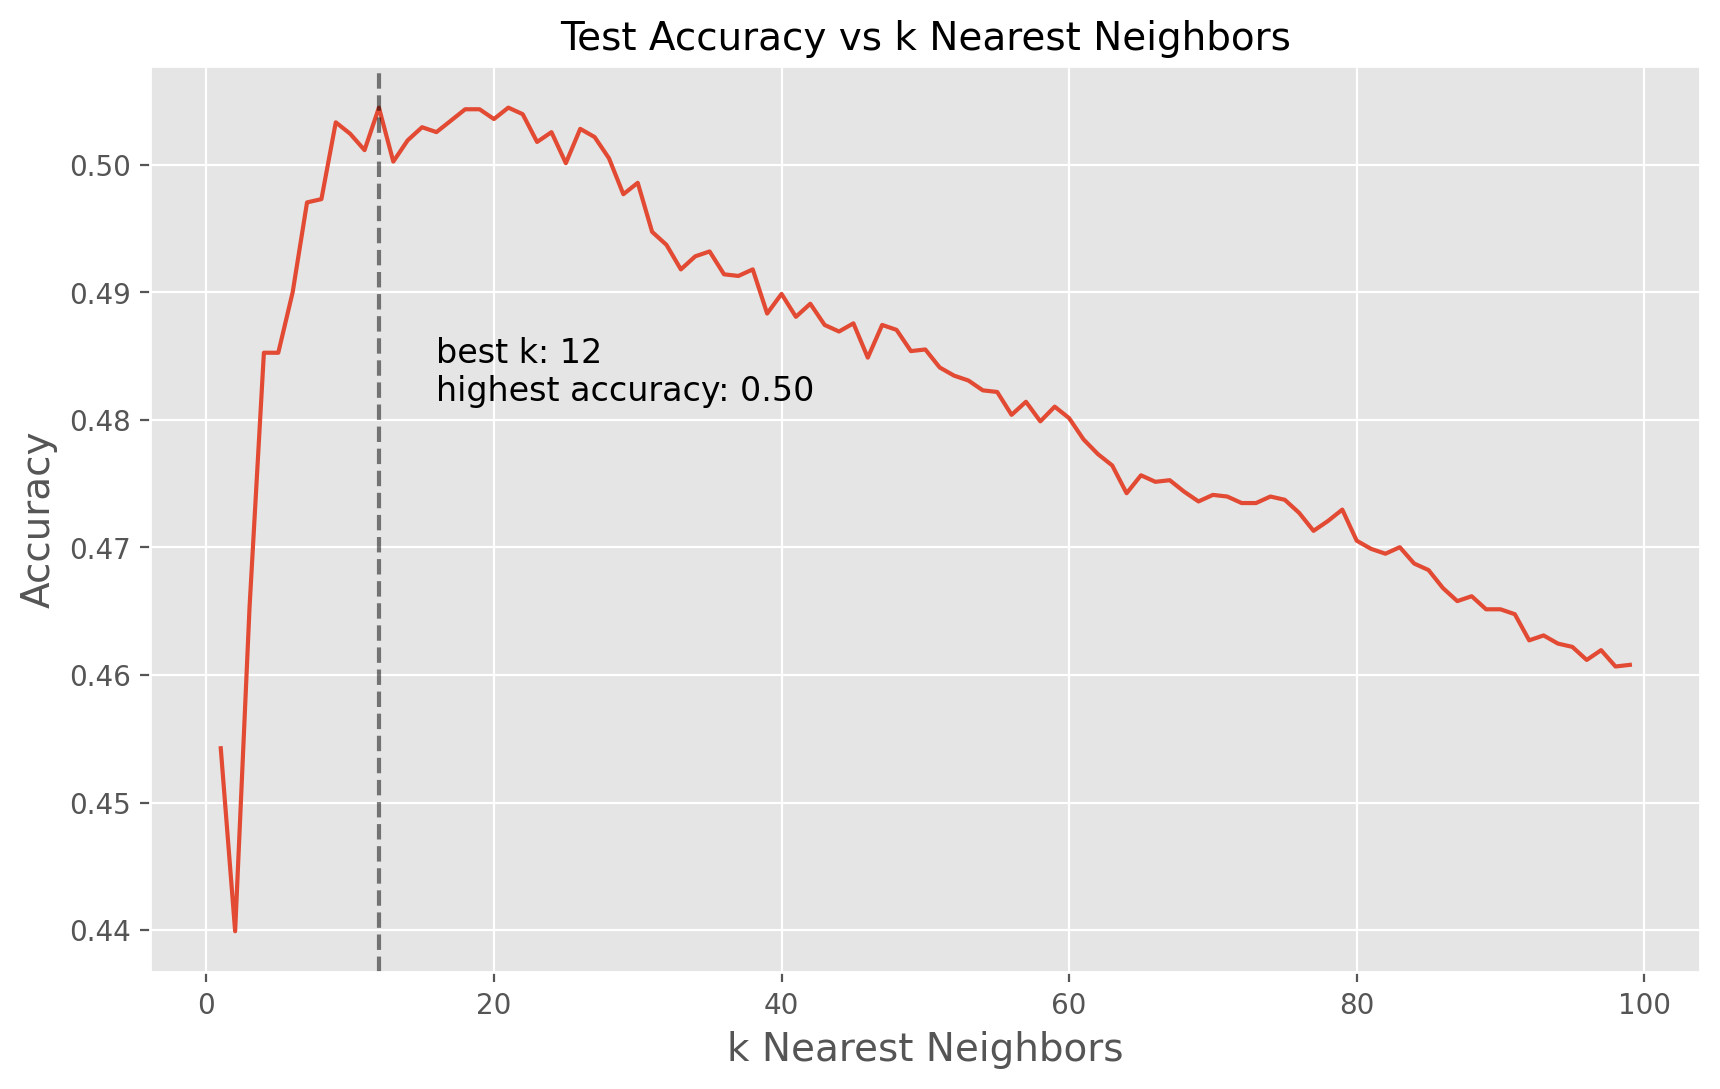

In [93]:
# Plot cross-validation scores for different numbers of
# nearest neighbors with 10 kfolds
cv_scores = []
max_score = 0
max_n = 0
for n in range(1,100):
    cv_score = cross_val(X_train, y_train, k=10, n=n)
    cv_scores.append(cv_score)
    if cv_score > max_score:
        max_score = cv_score
        max_n = n


fig, ax = plt.subplots(figsize=(10,6), dpi=200)    
ax.plot(list(range(1,100)),cv_scores)
ax.axvline(max_n, linestyle='--',c='k',alpha=0.5)
ax.text(max_n+4, max_score-0.023,
        s=f'best k: {max_n}\nhighest accuracy: {max_score:.2f}',
        fontsize=12)
ax.set_xlabel('k Nearest Neighbors', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.tick_params(axis='both',which='major',labelsize=10)
ax.set_title('Test Accuracy vs k Nearest Neighbors', fontsize=14);

plt.savefig('../imgs/accuracy_vs_nearestneighbors.png')

## Logistic Regression

In [25]:
# Out of Box score
log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
score = log_clf.score(X_val, y_val)
print(f'Accuracy = {score}')

log_clf = LogisticRegression()
log_clf.fit(Xf_train, yf_train)
score = log_clf.score(Xf_val, yf_val)
print(f'Accuracy = {score}')

/Users/ken/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy = 0.444672131147541
Accuracy = 0.11456991555746386


/Users/ken/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [34]:
# One versus rest (OVR) classification
log_clf = LogisticRegression(multi_class='ovr',max_iter=10000)
log_clf.fit(X_train, y_train)
score = log_clf.score(X_val, y_val)
print(f'Accuracy = {score}')

Accuracy = 0.6403688524590164


In [31]:
# Multinomial classification
log_clf = LogisticRegression(multi_class='multinomial',max_iter=10000)
log_clf.fit(X_train, y_train)
score = log_clf.score(X_val, y_val)
print(f'Accuracy = {score}')

Accuracy = 0.6644467213114754


/Users/ken/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Gradient Boosting

In [81]:
# Out of box score
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb.score(X_val, y_val)

0.7443647540983607

In [59]:
gb = GradientBoostingClassifier(n_estimators=200,learning_rate=.1)
gb.fit(X_train,y_train)
cross_val_score(estimator=gb,X=X_train_val,y=y_train_val,scoring='accuracy',cv=5)

array([0.73155738, 0.7505123 , 0.72745902, 0.73141978, 0.7457714 ])

In [69]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_features='sqrt', max_depth=3, random_state=0)
gb_clf.fit(X_train, y_train)

print("Learning rate: ", learning_rate)
print("Number of estimators: ", n_estimators)
print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}\n".format(gb_clf.score(X_val, y_val)))

Learning rate:  1
Number of estimators:  500
Accuracy score (training): 0.839
Accuracy score (validation): 0.741



In [72]:
max_depths = np.arange(1,10).tolist()
estimator_lst = [20, 50, 100, 200, 500]

best_depth, best_estimator = 0, 0

for n_estimators in estimator_lst:
    for depth in max_depths:
        gb_clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=0.1, max_features='sqrt', max_depth=depth, random_state=0)
        gb_clf.fit(X_train, y_train)

        # print("Max Depth: ", depth)
        # print("Number of estimators: ", n_estimators)
        # print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
        # print("Accuracy score (validation): {0:.3f}\n".format(gb_clf.score(X_val, y_val)))

Learning rate:  1
Number of estimators:  20
Accuracy score (training): 0.619
Accuracy score (validation): 0.617

Learning rate:  1
Number of estimators:  20
Accuracy score (training): 0.689
Accuracy score (validation): 0.665

Learning rate:  1
Number of estimators:  20
Accuracy score (training): 0.731
Accuracy score (validation): 0.694

Learning rate:  1
Number of estimators:  20
Accuracy score (training): 0.773
Accuracy score (validation): 0.709

Learning rate:  1
Number of estimators:  20
Accuracy score (training): 0.831
Accuracy score (validation): 0.713

Learning rate:  1
Number of estimators:  20
Accuracy score (training): 0.879
Accuracy score (validation): 0.726

Learning rate:  1
Number of estimators:  20
Accuracy score (training): 0.940
Accuracy score (validation): 0.725

Learning rate:  1
Number of estimators:  20
Accuracy score (training): 0.976
Accuracy score (validation): 0.717

Learning rate:  1
Number of estimators:  20
Accuracy score (training): 0.992
Accuracy score (val

KeyboardInterrupt: 

In [80]:
tuned_parameters = {'n_estimators': [10, 50, 100, 500, 1000],
                    'max_features': [1,2,3,4],
                    'max_depth':[1,3,5,7]}

print("# Tuning hyper-parameters for %s" % score)
print()

clf = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, scoring='accuracy',n_jobs=-1)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_val, clf.predict(X_val)
print(classification_report(y_true, y_pred))
print()

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'max_depth': 7, 'max_features': 4, 'n_estimators': 500}

Grid scores on development set:

0.407 (+/-0.052) for {'max_depth': 1, 'max_features': 1, 'n_estimators': 10}
0.604 (+/-0.033) for {'max_depth': 1, 'max_features': 1, 'n_estimators': 50}
0.645 (+/-0.030) for {'max_depth': 1, 'max_features': 1, 'n_estimators': 100}
0.713 (+/-0.025) for {'max_depth': 1, 'max_features': 1, 'n_estimators': 500}
0.720 (+/-0.022) for {'max_depth': 1, 'max_features': 1, 'n_estimators': 1000}
0.506 (+/-0.068) for {'max_depth': 1, 'max_features': 2, 'n_estimators': 10}
0.646 (+/-0.014) for {'max_depth': 1, 'max_features': 2, 'n_estimators': 50}
0.678 (+/-0.018) for {'max_depth': 1, 'max_features': 2, 'n_estimators': 100}
0.720 (+/-0.024) for {'max_depth': 1, 'max_features': 2, 'n_estimators': 500}
0.724 (+/-0.019) for {'max_depth': 1, 'max_features': 2, 'n_estimators': 1000}
0.529 (+/-0.031) for {'max_depth': 1, 'max_f

In [87]:
gb_final= GradientBoostingClassifier(random_state=0)
gb_final.fit(X_train, y_train)
gb_final.score(X_val, y_val)

0.7443647540983607